In [14]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax

from jax.random import PRNGKey, split
from jax import config, grad
from time import time
config.update("jax_enable_x64", True)

from data import generate_data, generate_observation_matrix, generate_sensing_matrices
from loss import create_l2_loss, create_mc_loss, create_gs_loss
from network import init_net, create_network, compute_prefactor, compress_network
from solver import train
from utils import svd, sensing_operator

## Low Rank (Square) Matrix Factorization

In [15]:
key = PRNGKey(0)

r = 5
input_dim = 2000
output_dim = 2000
depth = 3
init_type = "orth"
init_scale = 1e-3

key, data_key = split(key)
target = generate_data(key=data_key, shape=(output_dim, input_dim), rank=r)

key, weight_key = split(key)
init_weights = init_net(key=weight_key, input_dim=input_dim, output_dim=output_dim, width=input_dim, depth=depth, init_type="orth", init_scale=init_scale)
network_fn = create_network()
l2_loss_fn = create_l2_loss(target)

In [16]:
num_iters = 300
step_size = 5e2
weights, loss_list, time_list = train(
    init_weights=init_weights, 
    loss_fn=l2_loss_fn, 
    network_fn=network_fn,
    num_iters=num_iters,
    step_size=step_size, 
    save_weights=False
)

  0%|          | 0/300 [00:00<?, ?it/s]

In [17]:
V = compute_prefactor(init_weights, l2_loss_fn, network_fn, r)
U1 = init_weights[0] @ V / init_scale

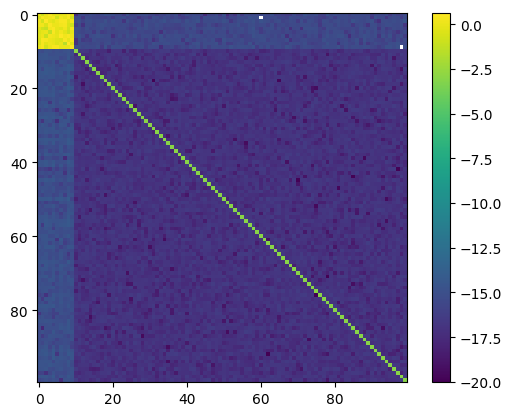

In [18]:
plt.imshow(jnp.log10(jnp.abs(U1.T @ weights[0] @ V))[:100, :100])
plt.colorbar()

In [19]:
comp_init_weights, V1_1, UL_1 = compress_network(init_weights, V, r)
comp_network_fn = create_network(pre=V1_1.T, post=UL_1)

In [20]:
num_iters = 300
step_size = 5e2
comp_weights, comp_loss_list, comp_time_list = train(
    init_weights=comp_init_weights, 
    loss_fn=l2_loss_fn,
    network_fn=comp_network_fn,
    num_iters=num_iters,
    step_size=step_size,
    save_weights=False,
)

  0%|          | 0/300 [00:00<?, ?it/s]

In [1]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), )

axes[0].plot(loss_list, linewidth=7, label='Original')
axes[0].plot(comp_loss_list, linewidth=3, label='Compressed')
axes[0].set_xlabel('Iteration', fontsize=15)
axes[0].set_ylabel('Loss', fontsize=15)
axes[0].legend(fontsize=12)

axes[1].plot(time_list, loss_list, linewidth=7, label='Original')
axes[1].plot(comp_time_list, comp_loss_list, linewidth=7, label='Compressed')
axes[1].set_xlabel('Time (s)', fontsize=15)
# axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=12)

plt.savefig("traj_vs_time.png", dpi=300, bbox_inches='tight')

NameError: name 'plt' is not defined

### What if we use a smaller width network (width=2r)

In [ ]:
key, weight_key = split(key)
narrow_init_weights = init_net(key=weight_key, input_dim=input_dim, output_dim=output_dim, width=2*r, depth=depth, init_type="orth", init_scale=init_scale)

In [ ]:
num_iters = 300
step_size = 5e2
narrow_weights, narrow_loss_list, narrow_time_list = train(
    init_weights=narrow_init_weights, 
    loss_fn=l2_loss_fn, 
    network_fn=network_fn,
    num_iters=num_iters,
    step_size=step_size, 
    save_weights=False
)

In [ ]:
plt.plot(loss_list, linewidth=7, label='Original')
plt.plot(comp_loss_list, linewidth=3, label='Compressed')
plt.plot(narrow_loss_list, linewidth=2, label='Narrow', linestyle='--')
plt.legend()

# Low Rank (Square) Matrix Completion

In [3]:
key, observation_key = split(key)
percent_observed = 0.5
observation_matrix = generate_observation_matrix(observation_key, percent_observed, (output_dim, input_dim))
mc_loss_fn = create_mc_loss(target, observation_matrix)

In [ ]:
num_iters = 300
step_size = 5e2
weights, loss_list, time_list = train(
    init_weights=init_weights, 
    loss_fn=mc_loss_fn, 
    network_fn=network_fn,
    num_iters=num_iters,
    step_size=step_size, 
    save_weights=False
)

In [5]:
V = compute_prefactor(init_weights, mc_loss_fn, network_fn, r)
U1 = init_weights[0] @ V / init_scale

In [ ]:
plt.imshow(jnp.log10(jnp.abs(U1.T @ weights[0] @ V)))
plt.colorbar()

In [6]:
comp_init_weights, V1_1, UL_1 = compress_network(init_weights, V, r)
comp_network_fn = create_network(pre=V1_1.T, post=UL_1)

In [ ]:
num_iters = 1000
step_size = 5e2
comp_weights, comp_loss_list, comp_time_list = train(
    init_weights=comp_init_weights, 
    loss_fn=mc_loss_fn,
    network_fn=comp_network_fn,
    num_iters=num_iters,
    step_size=step_size,
    save_weights=False,
)

In [ ]:
plt.plot(loss_list, linewidth=7, label='Original')
plt.plot(comp_loss_list, linewidth=3, label='Compressed')
plt.legend()

## Can we improve this? (Train factors with discrepant learning rate)

In [7]:
comp_rot_init_weights = [V1_1.T] + comp_init_weights + [UL_1]
comp_rot_network_fn = create_network()

In [9]:
num_iters = 1000
step_size = 5e2
comp_rot_weights, comp_rot_loss_list, comp_rot_time_list = train(
    init_weights=comp_rot_init_weights,
    loss_fn=mc_loss_fn,
    network_fn=comp_rot_network_fn,
    num_iters=num_iters,
    step_size=step_size,
    factors=True,
    save_weights=False
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
plt.semilogy(loss_list, linewidth=7, label='Original')
plt.semilogy(comp_rot_loss_list, linewidth=3, label='Compressed (w/ Rotation)')
plt.legend()

In [ ]:
plt.semilogy(time_list, loss_list, linewidth=7, label='Original')
plt.semilogy(comp_rot_time_list, comp_rot_loss_list, linewidth=3, label='Compressed (w/ Rotation)')
plt.legend()